In [ ]:
import numpy as np
def extractfeatures(x, sr, features):
    result = np.array([])

    for feature in features:
      if feature=='MFCC':
        #MFCC
        mfcc = np.mean(librosa.feature.mfcc(y=x, sr=sr).T, axis=0)
        result = np.hstack((result, mfcc)) 
      if feature=='Spectral Centroid':
        #Spectral Centroid
        specc = np.mean(librosa.feature.spectral_centroid(y=x, sr=sr)[0])
        result = np.hstack((result, specc))
      if feature=='Spectral Bandwidth':
        #Spectral Centroid
        specb = np.mean(librosa.feature.spectral_bandwidth(y=x, sr=sr)[0])
        result = np.hstack((result, specb)) 
      if feature=='Spectral Contrast':
        #Spectral Centroid
        speco = np.mean(librosa.feature.spectral_contrast(y=x, sr=sr)[0])
        result = np.hstack((result, speco))
      if feature=='Spectral Rolloff':
        #Spectral Rolloff
        specr = np.mean(librosa.feature.spectral_rolloff(y=x, sr=sr))
        result = np.hstack((result, specr))
      if feature=='Fourier Tempogram':
        #Fourier Tempogram
        fouriert = np.mean(librosa.feature.fourier_tempogram(y=x, sr=sr))
        result = np.hstack((result, fouriert))
      if feature=='Chroma':
        #Chroma
        chroma = np.abs(librosa.stft(x))
        chroma_stft = np.mean(librosa.feature.chroma_stft(S=chroma, sr=sr).T, axis=0)
        result = np.hstack((result, chroma_stft))
  
    return result

In [ ]:
import warnings
warnings.filterwarnings('ignore')
import librosa
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))
  
# Then move kaggle.json into the folder where the API expects to find it.
!mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json
User uploaded file "kaggle.json" with length 65 bytes


In [ ]:
!kaggle datasets download -d uwrfkaggler/ravdess-emotional-speech-audio

 97% 417M/429M [00:03<00:00, 122MB/s]
100% 429M/429M [00:03<00:00, 118MB/s]


In [ ]:
!unzip ravdess-emotional-speech-audio.zip -d /content/Actor_folders

In [ ]:
import os
from glob import iglob

rootdir_glob = '/content/Actor_folders/**/*' # Note the added asterisks
# This will return absolute paths
orig_file_list = [f for f in iglob(rootdir_glob, recursive=True) if os.path.isfile(f)]

In [ ]:
from random import sample
import copy
import sklearn

X=[]
y=[]

for i in range (len(orig_file_list)):

  x , sr = librosa.load(orig_file_list[i])
  result=extractfeatures(x, sr,['MFCC','Spectral Centroid','Spectral Rolloff','Spectral Contrast','Spectral Bandwidth'])
  X.append(result)

  audio_path=orig_file_list[i].split('/')[4:][0]
  parts=audio_path.split('.')[0].split('-')
  y.append(int(parts[2]))

y=np.array(y)
X=np.array(X)

y=y.reshape(-1,1)
X=X.reshape(X.shape[0],X.shape[1],1)

In [ ]:
def build_cnn_model(input_shape=(X.shape[1],1), num_class=9, dropout_rate=0.1):

  model = tf.keras.models.Sequential([
            tf.keras.layers.Conv1D(32*6, 3, activation='relu', input_shape=input_shape),
            tf.keras.layers.Dropout(dropout_rate),
            tf.keras.layers.MaxPooling1D(2),
            tf.keras.layers.Conv1D(64, 3, activation='relu'),
            tf.keras.layers.Dropout(dropout_rate),
            tf.keras.layers.MaxPooling1D(2),
            tf.keras.layers.Flatten(),
            tf.keras.layers.Dense(64, activation='relu'),
            tf.keras.layers.Dense(num_class, activation='softmax')
        ])
  # -------------------------------

  return model

In [ ]:
import matplotlib.pyplot as plt
def plot_history(history):
  # function to plot accuracy vs epoch

  plt.plot(history.history['accuracy'], label='accuracy')
  plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
  plt.xlabel('Epoch')
  plt.ylabel('Accuracy')
  plt.legend(loc='lower right')

Epoch 1/500
11/11 [==============================] - 1s 47ms/step - loss: 65.2520 - accuracy: 0.1204 - val_loss: 11.9016 - val_accuracy: 0.1250
Epoch 2/500
11/11 [==============================] - 0s 30ms/step - loss: 22.1919 - accuracy: 0.1412 - val_loss: 4.2811 - val_accuracy: 0.1736
Epoch 3/500
11/11 [==============================] - 0s 34ms/step - loss: 11.0501 - accuracy: 0.1474 - val_loss: 3.7897 - val_accuracy: 0.1597
Epoch 4/500
11/11 [==============================] - 0s 30ms/step - loss: 5.9343 - accuracy: 0.1566 - val_loss: 2.7178 - val_accuracy: 0.1181
Epoch 5/500
11/11 [==============================] - 0s 31ms/step - loss: 4.0688 - accuracy: 0.1705 - val_loss: 2.1876 - val_accuracy: 0.1667
Epoch 6/500
11/11 [==============================] - 0s 31ms/step - loss: 2.9103 - accuracy: 0.1798 - val_loss: 2.1128 - val_accuracy: 0.2361
Epoch 7/500
11/11 [==============================] - 0s 31ms/step - loss: 2.3003 - accuracy: 0.1698 - val_loss: 2.0093 - val_accuracy: 0.1875
Ep

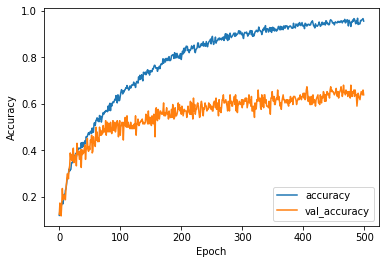

In [ ]:
from sklearn.model_selection import train_test_split
import tensorflow as tf

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.10, random_state=42)

model=build_cnn_model()
model.compile(optimizer=tf.keras.optimizers.Adam(), loss='sparse_categorical_crossentropy',metrics=['accuracy'])

history = model.fit(X_train, y_train, epochs=500, batch_size=128,validation_data=(X_test, y_test))

plot_history(history)
model.summary()